In [4]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/txn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
print(stopwords.words('english'))# printing the stopwords in English

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

# Load dataset

In [8]:
df = pd.read_csv('train.csv') # Only load train data, test data does not have label

In [9]:
df.shape # Size of data

(20800, 5)

In [10]:
df.head() # Show few lines

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
df.isnull().sum() # checking the missing values

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [12]:
#replacing null values with empty string
df = df.fillna('')

In [13]:
df.isnull().sum() # checking the missing values after replacing

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [14]:
# merging the author name and news title, using text will take a lot of time and doesn't give a better score
df['content'] = df['title'] + " " + df['author']

In [15]:
df.head() # Show first few lines

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [16]:
# separating the data & label
X = df.drop(columns='label', axis=1)
Y = df['label']

In [17]:
X.head() # Show first few lines

,id,title,author,text,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...


In [18]:
Y.head() # Show first few lines

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

# Stemming

In [23]:
# creating instance
ps = PorterStemmer()

def stemming(content):
    """
    Preprocesses text by removing non-alphabetic characters, converting to lowercase, applying Porter stemming, and removing English stopwords.
    Args: content (str): Raw text to process
    Returns: str: Stemmed text with stopwords removed
    """
    stemmed = re.sub('[^a-zA-Z]',' ',content) # replace non-alphabetic characters with ' '
    stemmed = stemmed.lower().strip() # convert to lower case and strip 
    stemmed = stemmed.split() # split all the words
    stemmed = [ps.stem(word) for word in stemmed if not word in stopwords.words('english')] # stemming and removing stopwords
    stemmed = ' '.join(stemmed) # joining all words with ' '
    return stemmed

In [24]:
# Test empty input
assert stemming("") == ""

# Test input with only stopwords
assert stemming("the and if or") == ""

# Test simple sentence
assert stemming("Dogs are running in the park") == "dog run park"

# Test punctuation removal
assert stemming("Breaking-news: Hello, World!") == "break news hello world"

# Test uppercase letters
assert stemming("NASA DISCOVERS WATER on Mars") == "nasa discov water mar"

# Test extra spaces and newlines
assert stemming("This   is\n\n a  test.") == "test"

print("✅ All tests passed!")

✅ All tests passed!


In [25]:
# Applying stemming on data
df['content']= df['content'].apply(stemming)

In [26]:
print(df['content']) # Show few lines after stemming

0        hous dem aid even see comey letter jason chaff...
1        flynn hillari clinton big woman campu breitbar...
2                   truth might get fire consortiumnew com
3        civilian kill singl us airstrik identifi jessi...
4        iranian woman jail fiction unpublish stori wom...
                               ...                        
20795    rapper trump poster child white supremaci jero...
20796    n f l playoff schedul matchup odd new york tim...
20797    maci said receiv takeov approach hudson bay ne...
20798    nato russia hold parallel exercis balkan alex ...
20799                            keep f aliv david swanson
Name: content, Length: 20800, dtype: object


In [35]:
#separating the stemmed contnent and label
X = df['content'].values
Y = df['label'].values

In [41]:
X.shape # Print the size of X

(20800,)

In [42]:
Y.shape # Print the size of Y

(20800,)

In [43]:
print(X)

['hous dem aid even see comey letter jason chaffetz tweet darrel lucu'
 'flynn hillari clinton big woman campu breitbart daniel j flynn'
 'truth might get fire consortiumnew com' ...
 'maci said receiv takeov approach hudson bay new york time michael j de la merc rachel abram'
 'nato russia hold parallel exercis balkan alex ansari'
 'keep f aliv david swanson']


In [44]:
print(Y)

[1 0 1 ... 0 1 1]


# Splitting training data & test data

In [46]:
# Splitting the dataset into training data and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

In [47]:
print(f"The size of X_train and Y_train is: {X_train.shape[0]}, {Y_train.shape[0]}")
print(f"The size of X_test and Y_test is: {X_test.shape[0]}, {Y_test.shape[0]}")

The size of X_train and Y_train is: 16640, 16640
The size of X_test and Y_test is: 4160, 4160


# TF-IDF
# Converting the textual data to numerical data

In [49]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=8000, stop_words='english')
# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)
# Transform the test data
X_test_tfidf = vectorizer.transform(X_test)

In [50]:
print(X_train_tfidf)

  (0, 5891)	0.29235417778668243
  (0, 6083)	0.29944195170366655
  (0, 1890)	0.41674388394569917
  (0, 7174)	0.2822008742391331
  (0, 1141)	0.27292483762227093
  (0, 6273)	0.3691563819883279
  (0, 6520)	0.2639960127462866
  (0, 5420)	0.3604641279405698
  (0, 1722)	0.2639960127462866
  (0, 6010)	0.3024304476824529
  (1, 2684)	0.3675070391121683
  (1, 5519)	0.3178765411296344
  (1, 7828)	0.39621151778309327
  (1, 7883)	0.4470806779849209
  (1, 1222)	0.29699945996442184
  (1, 1845)	0.28084701562561387
  (1, 6423)	0.2380136297694645
  (1, 5552)	0.2512112309250408
  (1, 923)	0.117982487593163
  (1, 7332)	0.23888181201538702
  (1, 517)	0.22181681170894307
  (2, 5468)	0.17008021637257964
  (2, 5613)	0.1976872020368141
  (2, 6155)	0.19006309397953497
  (2, 2527)	0.22403772067810737
  :	:
  (16637, 1457)	0.2913308437267557
  (16637, 146)	0.2691832452144586
  (16637, 5722)	0.31207049539226706
  (16637, 6422)	0.30192776460451737
  (16637, 5222)	0.27665709447327586
  (16637, 64)	0.336867742592724
 

In [51]:
print(X_test_tfidf)

  (0, 454)	0.3906916980054898
  (0, 517)	0.24307881867198472
  (0, 1584)	0.34834624799637226
  (0, 1790)	0.33012390417312604
  (0, 2182)	0.31568893737465076
  (0, 4065)	0.24561655550358755
  (0, 4798)	0.0891816776030938
  (0, 5222)	0.2504652565052958
  (0, 5433)	0.31933121949599186
  (0, 6503)	0.30776729797831764
  (0, 7202)	0.09052751447820247
  (0, 7367)	0.11442218987767082
  (0, 7741)	0.3174704759280198
  (0, 7959)	0.09221855354956901
  (1, 726)	0.2863317218862082
  (1, 909)	0.3798050060550041
  (1, 1023)	0.29602199766365117
  (1, 1156)	0.3798050060550041
  (1, 1765)	0.2520089430809932
  (1, 3950)	0.39705411006633545
  (1, 3982)	0.25165880509665883
  (1, 4498)	0.3354999700588543
  (1, 4522)	0.19670351352308887
  (1, 4798)	0.09063400071127614
  (1, 4939)	0.2840316198437759
  :	:
  (4157, 4703)	0.30809220806760534
  (4157, 5190)	0.6836848898718155
  (4157, 6904)	0.3238788712277643
  (4158, 377)	0.26385517470085146
  (4158, 927)	0.3071134910128232
  (4158, 1268)	0.22097966439898425
  (

In [52]:
# Print the size of each dataset
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(16640, 8000)
(4160, 8000)


# SVM-TF-IDF

In [54]:
# Create and train an SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, Y_train)

SVC(kernel='linear')

In [55]:
# Make predictions on the training set
Y_train_pred_svm = svm_model.predict(X_train_tfidf)

# Evaluate the model on the training set
train_accuracy_svm = accuracy_score(Y_train, Y_train_pred_svm)
print(f"SVM Training Accuracy: {train_accuracy_svm:.2f}")

SVM Training Accuracy: 1.00


In [56]:
# Make predictions on the test set
Y_test_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the model on the test set
test_accuracy_svm = accuracy_score(Y_test, Y_test_pred_svm)
print(f"SVM Test Accuracy: {test_accuracy_svm:}")

# Calculate precision, recall, and F1 score for the test set
classification_report_svm = classification_report(Y_test, Y_test_pred_svm)
print(f"SVM Classification Report:\n{classification_report_svm}")

SVM Test Accuracy: 0.9918269230769231
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2085
           1       0.99      0.99      0.99      2075

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



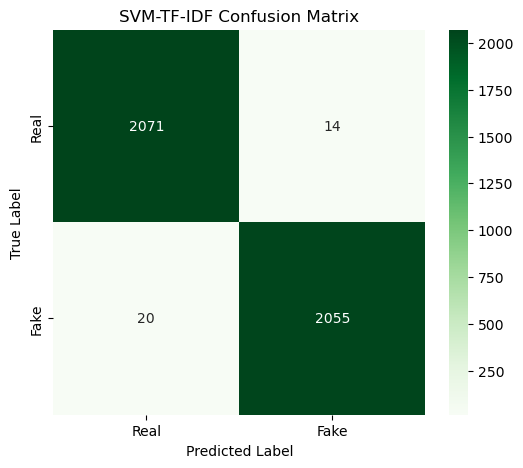

In [57]:
# Create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred_svm)

# Display the confusion matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("SVM-TF-IDF Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [98]:
# Identify misclassified indices
wrong_indices = np.where(Y_test_pred_svm != Y_test)[0]

# False positives: predicted FAKE (1), actually REAL (0)
fp_indices = [i for i in wrong_indices if Y_test[i] == 0 and Y_test_pred_svm[i] == 1]
fp_texts = [X_test[i] for i in fp_indices]
fp_words = " ".join(fp_texts).split()
fp_word_counts = Counter(fp_words)
top_fp_words = fp_word_counts.most_common(20)

# False negatives: predicted REAL (0), actually FAKE (1)
fn_indices = [i for i in wrong_indices if Y_test[i] == 1 and Y_test_pred_svm[i] == 0]
fn_texts = [X_test[i] for i in fn_indices]
fn_words = " ".join(fn_texts).split()
fn_word_counts = Counter(fn_words)
top_fn_words = fn_word_counts.most_common(20)

# Print top frequent words in each category
print("Top words in false positives (predicted FAKE, actually REAL):")
print(top_fp_words)

print("\nTop words in false negatives (predicted REAL, actually FAKE):")
print(top_fn_words)

Top words in false positives (predicted FAKE, actually REAL):
[('trump', 4), ('john', 3), ('j', 3), ('xenaki', 3), ('victoria', 2), ('friedman', 2), ('get', 2), ('percent', 2), ('news', 2), ('bardot', 1), ('see', 1), ('macron', 1), ('lack', 1), ('empathi', 1), ('cold', 1), ('steel', 1), ('eye', 1), ('growth', 1), ('despit', 1), ('predict', 1)]

Top words in false negatives (predicted REAL, actually FAKE):
[('new', 9), ('york', 7), ('time', 7), ('clinton', 3), ('home', 2), ('thoma', 2), ('maxrockatanski', 2), ('report', 2), ('edjenn', 2), ('ph', 2), ('hillari', 2), ('trump', 2), ('bob', 2), ('top', 1), ('remedi', 1), ('stuffi', 1), ('nose', 1), ('mandi', 1), ('wong', 1), ('faddi', 1)]


# RANDOM FOREST - TF-IDF

In [101]:
from sklearn.ensemble import RandomForestClassifier
# Create and train the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0, n_estimators=100)
rf_model.fit(X_train_tfidf, Y_train)

RandomForestClassifier(random_state=0)

In [102]:
# Make predictions on the training set
Y_train_pred_rf = rf_model.predict(X_train_tfidf)

# Evaluate the model on the training set
train_accuracy_rf = accuracy_score(Y_train, Y_train_pred_rf)
print(f"Random Forest Training Accuracy: {train_accuracy_svm:.2f}")

Random Forest Training Accuracy: 1.00


In [103]:
# Make predictions on the test set
Y_test_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the model on the test set
test_accuracy_rf = accuracy_score(Y_test, Y_test_pred_rf)
print(f"Random Forest Test Accuracy: {test_accuracy_rf:}")

# Calculate precision, recall, and F1 score for the test set
classification_report_rf = classification_report(Y_test, Y_test_pred_rf)
print(f"Random Forest Classification Report:\n{classification_report_rf}")

Random Forest Test Accuracy: 0.9935096153846154
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2085
           1       0.99      1.00      0.99      2075

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



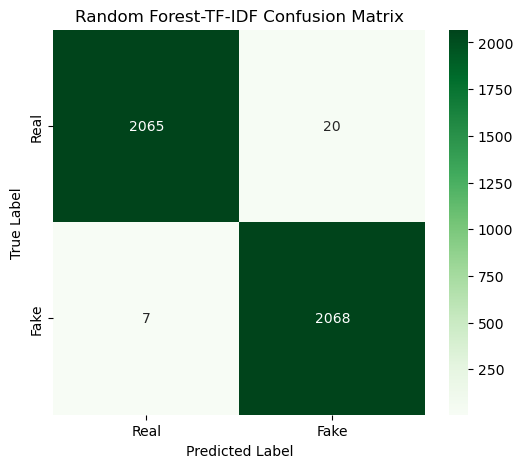

In [104]:
# Create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred_rf)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Random Forest-TF-IDF Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [105]:
# Identify misclassified indices
wrong_indices = np.where(Y_test_pred_rf != Y_test)[0]

# False positives: predicted FAKE (1), actually REAL (0)
fp_indices = [i for i in wrong_indices if Y_test[i] == 0 and Y_test_pred_rf[i] == 1]
fp_texts = [X_test[i] for i in fp_indices]
fp_words = " ".join(fp_texts).split()
fp_word_counts = Counter(fp_words)
top_fp_words = fp_word_counts.most_common(20)

# False negatives: predicted REAL (0), actually FAKE (1)
fn_indices = [i for i in wrong_indices if Y_test[i] == 1 and Y_test_pred_rf[i] == 0]
fn_texts = [X_test[i] for i in fn_indices]
fn_words = " ".join(fn_texts).split()
fn_word_counts = Counter(fn_words)
top_fn_words = fn_word_counts.most_common(20)

# Print top frequent words in each category
print("Top words in false positives (predicted FAKE, actually REAL):")
print(top_fp_words)

print("\nTop words in false negatives (predicted REAL, actually FAKE):")
print(top_fn_words)

Top words in false positives (predicted FAKE, actually REAL):
[('virgil', 4), ('trump', 3), ('lana', 3), ('shadwick', 3), ('get', 2), ('percent', 2), ('state', 2), ('news', 2), ('support', 2), ('jay', 2), ('h', 2), ('lehr', 2), ('year', 2), ('old', 2), ('girl', 2), ('john', 2), ('j', 2), ('xenaki', 2), ('media', 2), ('jame', 2)]

Top words in false negatives (predicted REAL, actually FAKE):
[('new', 5), ('york', 5), ('time', 4), ('maxrockatanski', 2), ('report', 2), ('edjenn', 2), ('top', 1), ('home', 1), ('remedi', 1), ('stuffi', 1), ('nose', 1), ('mandi', 1), ('wong', 1), ('comment', 1), ('call', 1), ('obama', 1), ('support', 1), ('un', 1), ('resolut', 1), ('would', 1)]


# NAIVE BAYES - TF-IDF

In [111]:
from sklearn.naive_bayes import MultinomialNB
# Create and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, Y_train)

MultinomialNB()

In [113]:
# Make predictions on the training set
Y_train_pred_nb = nb_model.predict(X_train_tfidf)

# Evaluate the model on the training set
train_accuracy_nb = accuracy_score(Y_train, Y_train_pred_nb)
print(f"Naive Bayes Training Accuracy: {train_accuracy_nb:.2f}")

Naive Bayes Training Accuracy: 0.97


In [115]:
# Make predictions on the test set
Y_test_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate the model on the test set
test_accuracy_nb = accuracy_score(Y_test, Y_test_pred_nb)
print(f"Naive Bayes Test Accuracy: {test_accuracy_nb:}")

# Calculate precision, recall, and F1 score for the test set
classification_report_nb = classification_report(Y_test, Y_test_pred_nb)
print(f"Naive Bayes Classification Report:\n{classification_report_nb}")

Naive Bayes Test Accuracy: 0.9538461538461539
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2085
           1       0.99      0.91      0.95      2075

    accuracy                           0.95      4160
   macro avg       0.96      0.95      0.95      4160
weighted avg       0.96      0.95      0.95      4160



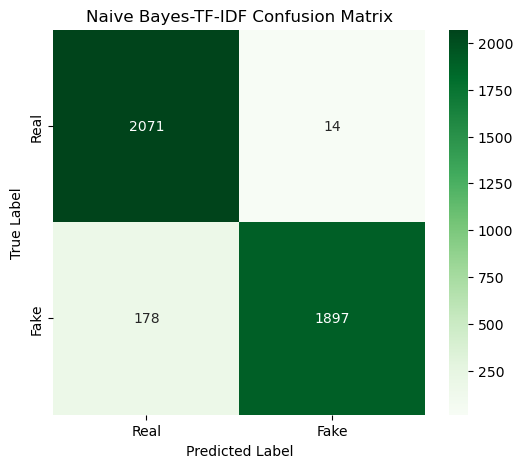

In [117]:
# Create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred_nb)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Naive Bayes-TF-IDF Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [119]:
# Identify misclassified indices
wrong_indices = np.where(Y_test_pred_nb != Y_test)[0]

# False positives: predicted FAKE (1), actually REAL (0)
fp_indices = [i for i in wrong_indices if Y_test[i] == 0 and Y_test_pred_nb[i] == 1]
fp_texts = [X_test[i] for i in fp_indices]
fp_words = " ".join(fp_texts).split()
fp_word_counts = Counter(fp_words)
top_fp_words = fp_word_counts.most_common(20)

# False negatives: predicted REAL (0), actually FAKE (1)
fn_indices = [i for i in wrong_indices if Y_test[i] == 1 and Y_test_pred_nb[i] == 0]
fn_texts = [X_test[i] for i in fn_indices]
fn_words = " ".join(fn_texts).split()
fn_word_counts = Counter(fn_words)
top_fn_words = fn_word_counts.most_common(20)

# Print top frequent words in each category
print("Top words in false positives (predicted FAKE, actually REAL):")
print(top_fp_words)

print("\nTop words in false negatives (predicted REAL, actually FAKE):")
print(top_fn_words)

Top words in false positives (predicted FAKE, actually REAL):
[('breitbart', 4), ('trump', 3), ('news', 3), ('john', 3), ('obama', 2), ('impeach', 2), ('elect', 2), ('aaron', 2), ('klein', 2), ('russia', 2), ('j', 2), ('xenaki', 2), ('virgil', 2), ('media', 2), ('cold', 2), ('demand', 2), ('hillari', 2), ('email', 2), ('clinton', 2), ('new', 2)]

Top words in false negatives (predicted REAL, actually FAKE):
[('trump', 18), ('say', 11), ('time', 11), ('new', 11), ('news', 10), ('obama', 7), ('call', 7), ('ban', 7), ('israel', 6), ('one', 6), ('mike', 6), ('penc', 6), ('clinton', 6), ('u', 6), ('polic', 6), ('donald', 6), ('russia', 5), ('report', 5), ('michael', 5), ('find', 5)]


# BoW

In [121]:
from sklearn.feature_extraction.text import CountVectorizer
# Create a BoW vectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_features=8000)
# Fit and transform the training data
X_train_bow = count_vectorizer.fit_transform(X_train)
# Transform the test data
X_test_bow = count_vectorizer.transform(X_test)

In [123]:
print(X_train_bow)

  (0, 5891)	1
  (0, 6083)	1
  (0, 1890)	1
  (0, 7174)	1
  (0, 1141)	1
  (0, 6273)	1
  (0, 6520)	1
  (0, 5420)	1
  (0, 1722)	1
  (0, 6010)	1
  (1, 2684)	1
  (1, 5519)	1
  (1, 7828)	2
  (1, 7883)	2
  (1, 1222)	1
  (1, 1845)	1
  (1, 6423)	1
  (1, 5552)	1
  (1, 923)	1
  (1, 7332)	1
  (1, 517)	1
  (2, 5468)	1
  (2, 5613)	1
  (2, 6155)	1
  (2, 2527)	1
  :	:
  (16637, 1457)	1
  (16637, 146)	1
  (16637, 5722)	1
  (16637, 6422)	1
  (16637, 5222)	1
  (16637, 64)	1
  (16637, 4417)	1
  (16637, 2631)	1
  (16637, 3729)	1
  (16638, 7325)	1
  (16638, 1169)	1
  (16638, 2575)	1
  (16638, 6860)	1
  (16638, 5291)	1
  (16638, 1713)	1
  (16638, 31)	1
  (16639, 1141)	1
  (16639, 428)	1
  (16639, 1226)	1
  (16639, 7671)	1
  (16639, 6433)	1
  (16639, 451)	1
  (16639, 7239)	1
  (16639, 5311)	1
  (16639, 4905)	1


In [125]:
print(X_test_bow)

  (0, 454)	1
  (0, 517)	1
  (0, 1584)	1
  (0, 1790)	1
  (0, 2182)	1
  (0, 4065)	1
  (0, 4798)	1
  (0, 5222)	1
  (0, 5433)	1
  (0, 6503)	1
  (0, 7202)	1
  (0, 7367)	1
  (0, 7741)	1
  (0, 7959)	1
  (1, 726)	1
  (1, 909)	1
  (1, 1023)	1
  (1, 1156)	1
  (1, 1765)	1
  (1, 3950)	1
  (1, 3982)	1
  (1, 4498)	1
  (1, 4522)	1
  (1, 4798)	1
  (1, 4939)	1
  :	:
  (4157, 4703)	1
  (4157, 5190)	2
  (4157, 6904)	1
  (4158, 377)	1
  (4158, 927)	1
  (4158, 1268)	1
  (4158, 2191)	1
  (4158, 3721)	1
  (4158, 3998)	1
  (4158, 4712)	1
  (4158, 4822)	1
  (4158, 5272)	1
  (4158, 5406)	1
  (4158, 6717)	1
  (4158, 7741)	1
  (4159, 136)	1
  (4159, 162)	1
  (4159, 367)	1
  (4159, 379)	1
  (4159, 402)	1
  (4159, 1206)	1
  (4159, 5205)	1
  (4159, 5613)	1
  (4159, 5943)	1
  (4159, 7064)	1


In [127]:
# Print the size of each dataset
print(X_train_bow.shape)
print(X_test_bow.shape)

(16640, 8000)
(4160, 8000)


# SVM-BoW

In [130]:
# Create and train an SVM classifier
svm_model_bow = SVC(kernel='linear')
svm_model_bow.fit(X_train_bow, Y_train)

SVC(kernel='linear')

In [131]:
# Make predictions on the training set
Y_train_pred_svm_bow = svm_model_bow.predict(X_train_bow)

# Evaluate the model on the training set
train_accuracy_svm_bow = accuracy_score(Y_train, Y_train_pred_svm_bow)
print(f"SVM Training Accuracy: {train_accuracy_svm_bow:.2f}")

SVM Training Accuracy: 1.00


In [132]:
# Make predictions on the test set
Y_test_pred_svm_bow = svm_model_bow.predict(X_test_bow)

# Evaluate the model on the test set
test_accuracy_svm_bow = accuracy_score(Y_test, Y_test_pred_svm_bow)
print(f"SVM Test Accuracy: {test_accuracy_svm_bow:}")

# Calculate precision, recall, and F1 score for the test set
classification_report_svm_bow = classification_report(Y_test, Y_test_pred_svm_bow)
print(f"SVM Classification Report:\n{classification_report_svm_bow}")

SVM Test Accuracy: 0.9930288461538461
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2085
           1       0.99      0.99      0.99      2075

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



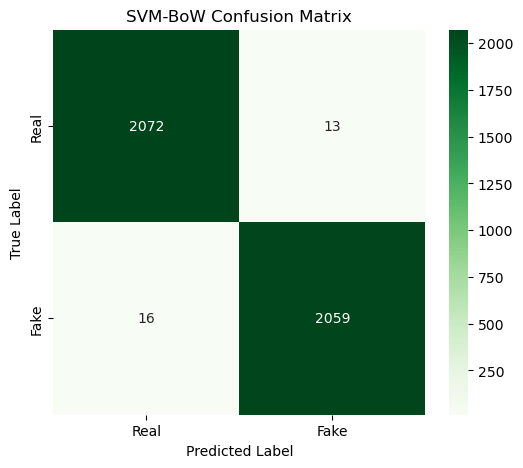

In [133]:
# Create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred_svm_bow)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("SVM-BoW Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [138]:
# Identify misclassified indices
wrong_indices = np.where(Y_test_pred_svm_bow != Y_test)[0]

# False positives: predicted FAKE (1), actually REAL (0)
fp_indices = [i for i in wrong_indices if Y_test[i] == 0 and Y_test_pred_svm_bow[i] == 1]
fp_texts = [X_test[i] for i in fp_indices]
fp_words = " ".join(fp_texts).split()
fp_word_counts = Counter(fp_words)
top_fp_words = fp_word_counts.most_common(20)

# False negatives: predicted REAL (0), actually FAKE (1)
fn_indices = [i for i in wrong_indices if Y_test[i] == 1 and Y_test_pred_svm_bow[i] == 0]
fn_texts = [X_test[i] for i in fn_indices]
fn_words = " ".join(fn_texts).split()
fn_word_counts = Counter(fn_words)
top_fn_words = fn_word_counts.most_common(20)

# Print top frequent words in each category
print("Top words in false positives (predicted FAKE, actually REAL):")
print(top_fp_words)

print("\nTop words in false negatives (predicted REAL, actually FAKE):")
print(top_fn_words)

Top words in false positives (predicted FAKE, actually REAL):
[('al', 3), ('trump', 3), ('john', 3), ('qaeda', 2), ('u', 2), ('neil', 2), ('say', 2), ('anti', 2), ('immigr', 2), ('simon', 2), ('kent', 2), ('j', 2), ('xenaki', 2), ('shabaab', 1), ('affili', 1), ('somalia', 1), ('satan', 1), ('time', 1), ('edwin', 1), ('mora', 1)]

Top words in false negatives (predicted REAL, actually FAKE):
[('new', 8), ('york', 7), ('time', 6), ('ban', 3), ('maxrockatanski', 2), ('report', 2), ('edjenn', 2), ('wake', 2), ('hope', 2), ('hillari', 2), ('billion', 2), ('tim', 2), ('kain', 2), ('cathol', 2), ('church', 2), ('chang', 2), ('sex', 2), ('marriag', 2), ('stanc', 2), ('u', 2)]


# RANDOM FOREST - BoW

In [140]:
# Create and train the RandomForestClassifier
rf_model_bow = RandomForestClassifier(random_state=0, n_estimators=100)
rf_model_bow.fit(X_train_bow, Y_train)

RandomForestClassifier(random_state=0)

In [141]:
# Make predictions on the training set
Y_train_pred_rf_bow = rf_model_bow.predict(X_train_bow)

# Evaluate the model on the training set
train_accuracy_rf_bow = accuracy_score(Y_train, Y_train_pred_rf_bow)
print(f"Random Forest Training Accuracy: {train_accuracy_rf_bow:.2f}")

Random Forest Training Accuracy: 1.00


In [142]:
# Make predictions on the test set
Y_test_pred_rf_bow = rf_model_bow.predict(X_test_bow)

# Evaluate the model on the test set
test_accuracy_rf_bow = accuracy_score(Y_test, Y_test_pred_rf_bow)
print(f"Random Forest Test Accuracy: {test_accuracy_rf_bow:}")

# Calculate precision, recall, and F1 score for the test set
classification_report_rf_bow = classification_report(Y_test, Y_test_pred_rf_bow)
print(f"Random Forest Classification Report:\n{classification_report_rf_bow}")

Random Forest Test Accuracy: 0.9927884615384616
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2085
           1       0.99      1.00      0.99      2075

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



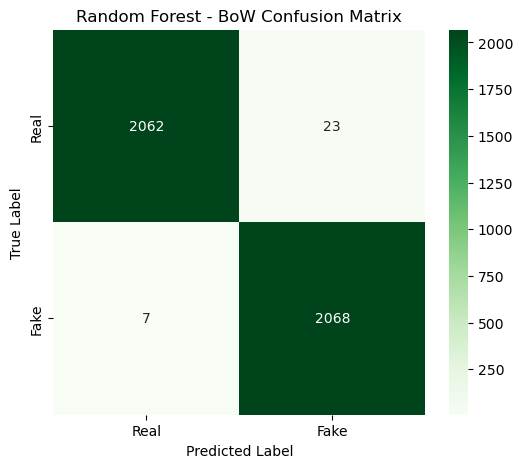

In [143]:
# Create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred_rf_bow)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Random Forest - BoW Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [148]:
# Identify misclassified indices
wrong_indices = np.where(Y_test_pred_rf_bow != Y_test)[0]

# False positives: predicted FAKE (1), actually REAL (0)
fp_indices = [i for i in wrong_indices if Y_test[i] == 0 and Y_test_pred_rf_bow[i] == 1]
fp_texts = [X_test[i] for i in fp_indices]
fp_words = " ".join(fp_texts).split()
fp_word_counts = Counter(fp_words)
top_fp_words = fp_word_counts.most_common(20)

# False negatives: predicted REAL (0), actually FAKE (1)
fn_indices = [i for i in wrong_indices if Y_test[i] == 1 and Y_test_pred_rf_bow[i] == 0]
fn_texts = [X_test[i] for i in fn_indices]
fn_words = " ".join(fn_texts).split()
fn_word_counts = Counter(fn_words)
top_fn_words = fn_word_counts.most_common(20)

# Print top frequent words in each category
print("Top words in false positives (predicted FAKE, actually REAL):")
print(top_fp_words)

print("\nTop words in false negatives (predicted REAL, actually FAKE):")
print(top_fn_words)

Top words in false positives (predicted FAKE, actually REAL):
[('virgil', 6), ('trump', 5), ('media', 3), ('john', 3), ('j', 3), ('xenaki', 3), ('get', 2), ('percent', 2), ('deal', 2), ('jack', 2), ('news', 2), ('record', 2), ('jay', 2), ('h', 2), ('lehr', 2), ('begin', 2), ('year', 2), ('old', 2), ('girl', 2), ('u', 2)]

Top words in false negatives (predicted REAL, actually FAKE):
[('new', 5), ('york', 5), ('time', 4), ('maxrockatanski', 2), ('report', 2), ('edjenn', 2), ('top', 1), ('home', 1), ('remedi', 1), ('stuffi', 1), ('nose', 1), ('mandi', 1), ('wong', 1), ('comment', 1), ('call', 1), ('obama', 1), ('support', 1), ('un', 1), ('resolut', 1), ('would', 1)]


# Naive Bayes - BoW

In [150]:
# Create and train the Naive Bayes model
nb_model_bow = MultinomialNB()
nb_model_bow.fit(X_train_bow, Y_train)

MultinomialNB()

In [152]:
# Make predictions on the training set
Y_train_pred_nb_bow = nb_model_bow.predict(X_train_bow)

# Evaluate the model on the training set
train_accuracy_nb_bow = accuracy_score(Y_train, Y_train_pred_nb_bow)
print(f"NB Training Accuracy: {train_accuracy_nb_bow:}")

NB Training Accuracy: 0.97890625


In [154]:
# Make predictions on the test set
Y_test_pred_nb_bow = nb_model_bow.predict(X_test_bow)

# Evaluate the model on the test set
test_accuracy_nb_bow = accuracy_score(Y_test, Y_test_pred_nb_bow)
print(f"NB Test Accuracy: {test_accuracy_nb_bow:}")

# Calculate precision, recall, and F1 score for the test set
classification_report_nb_bow = classification_report(Y_test, Y_test_pred_nb_bow)
print(f"NB Classification Report:\n{classification_report_nb_bow}")

NB Test Accuracy: 0.9622596153846154
NB Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2085
           1       0.99      0.93      0.96      2075

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



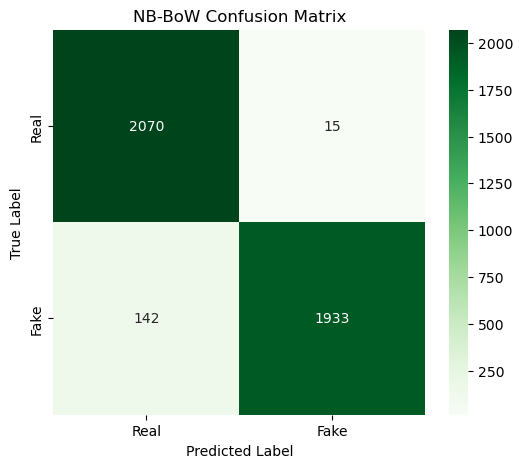

In [156]:
# Create a confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_test_pred_nb_bow)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("NB-BoW Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [158]:
# Identify misclassified indices
wrong_indices = np.where(Y_test_pred_nb_bow != Y_test)[0]

# False positives: predicted FAKE (1), actually REAL (0)
fp_indices = [i for i in wrong_indices if Y_test[i] == 0 and Y_test_pred_nb_bow[i] == 1]
fp_texts = [X_test[i] for i in fp_indices]
fp_words = " ".join(fp_texts).split()
fp_word_counts = Counter(fp_words)
top_fp_words = fp_word_counts.most_common(20)

# False negatives: predicted REAL (0), actually FAKE (1)
fn_indices = [i for i in wrong_indices if Y_test[i] == 1 and Y_test_pred_nb_bow[i] == 0]
fn_texts = [X_test[i] for i in fn_indices]
fn_words = " ".join(fn_texts).split()
fn_word_counts = Counter(fn_words)
top_fn_words = fn_word_counts.most_common(20)

# Print top frequent words in each category
print("Top words in false positives (predicted FAKE, actually REAL):")
print(top_fp_words)

print("\nTop words in false negatives (predicted REAL, actually FAKE):")
print(top_fn_words)

Top words in false positives (predicted FAKE, actually REAL):
[('john', 5), ('media', 5), ('obama', 4), ('aaron', 3), ('klein', 3), ('hayward', 3), ('trump', 2), ('j', 2), ('xenaki', 2), ('virgil', 2), ('news', 2), ('video', 1), ('ex', 1), ('staffer', 1), ('urg', 1), ('spi', 1), ('predict', 1), ('quick', 1), ('impeach', 1), ('week', 1)]

Top words in false negatives (predicted REAL, actually FAKE):
[('time', 18), ('trump', 17), ('new', 17), ('say', 9), ('call', 7), ('ban', 6), ('u', 6), ('israel', 5), ('york', 5), ('donald', 5), ('obama', 4), ('parti', 4), ('take', 4), ('news', 4), ('thoma', 4), ('attack', 4), ('polic', 4), ('chang', 4), ('life', 4), ('offic', 4)]
